In [1]:
# display result of assignments
#%config ZMQInteractiveShell.ast_node_interactivity = 'last_expr_or_assign'
# make NumPy display a bit nicer
#np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:10.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})
# make cells nice and wide
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def clean_ax(ax, x_range, y_range, spines=False, legend=False):
    if legend:
        ax.legend(loc="upper left")
    if not spines:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
    plt.setp(ax, xticks=(), yticks=(), xlim=x_range, ylim=y_range)

# Dynamical Movement Primitive (DMPs)

DMPs are trajectory representations that

* are goal-directed
* are robust to perturbations and noise (like potential fields)
* are arbitrarily shapeable
* can be scaled and translated arbitrarily, even online
* are parametrized policy representations that can be used for reinforcement learning
* can be used for imitation learning

They have drawbacks:

* an inverse (velocity) kinematics is required to execute task space trajectories
* they are usually not able to learn from multiple demonstrations

There are different variants of DMPs in the literature [1, 2, 3].

[1] Ijspeert, Auke Jan; Nakanishi, Jun; Hoffmann, Heiko; Pastor, Peter; Schaal, Stefan: Dynamical movement primitives: learning attractor models for motor behaviors, Neural computation 25 (2), pp. 328-373, 2013.

[2] Pastor, Peter; Hoffmann, Heiko; Asfour, Tamim; Schaal, Stefan: Learning and generalization of motor skills by learning from demonstration, Proceedings of the IEEE International Conference on Robotics and Automation, pp. 763-768, 2009.

[3] Muelling, Katharina; Kober, Jens; Kroemer, Oliver; Peters, Jan: Learning to Select and Generalize Striking Movements in Robot Table Tennis, International Journal of Robotics Research 32 (3), 2013.

## Dynamical System

A fixed rule describes how a point in geometrical space depends on time.

* At any time $t$, a dynamical system has a state $\boldsymbol{x} \in S \subseteq \mathbb{R}^n$
* Small changes in the systems state create small changes in $\boldsymbol{x}$
* The evolution rule $f(\boldsymbol{x}_t) = \boldsymbol{x}_{t+1}$ is a fixed, deterministic rule that describes what future states follow from the current state

## Mass-spring-damper

![Spring-damper](http://upload.wikimedia.org/wikipedia/commons/3/35/%D0%9A%D0%BE%D0%BB%D0%B8%D0%B2%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%B0_%D1%96%D0%B7_%D0%BF%D1%80%D1%83%D0%B6%D0%B8%D0%BD%D0%BE%D1%8E_%D1%82%D0%B0_%D0%B4%D0%B5%D0%BC%D0%BF%D1%84%D0%B5%D1%80%D0%BE%D0%BC.png)

* An oscillatory force $F_s = -k x$
* and a damping force $F_d = -c \dot{x}$
* result in a total force $F_{tot} = m \ddot{x}$

$$F_{tot} = F_s + F_d \Leftrightarrow \ddot{x} + \frac{c}{m} \dot{x} + \frac{k}{m} x = 0$$

The system is **critically damped**, i.e. it converges to zero as fast as possible without oscillating (overshoot can occur), iff
$$c = 2 \sqrt{mk} \Leftrightarrow \zeta = \frac{c}{2 \sqrt{mk}} = 1$$
It is **over-damped** (too slow) iff
$$\zeta > 1$$
and **under-damped** (oscillating) iff
$$0 \leq \zeta < 1$$

[Wikipedia: Damping](http://en.wikipedia.org/wiki/Damping)

The dynamical system that we use in a Dynamical Movement Primitive is based on a spring-damper system with $m=1$.  $$\textbf{The original formulation by Ijspeert et al}$$ (First DMP paper).  computes the acceleration by
$$\ddot{x} = \frac{\alpha}{\tau^2} \left(\beta (g - x) - \tau \dot{x}\right),$$
which can be reformulated as
$$x + \frac{\tau}{\beta} \dot{x} + \frac{\tau^2}{\alpha \beta} \ddot{x} = g,$$
so that critical damping is achieved with
$$\frac{\tau}{\beta} = 2 \sqrt{\frac{\tau^2}{\alpha \beta}}
  \Leftrightarrow \frac{\alpha}{4} = \beta.$$

spring mass system eqn and visualization

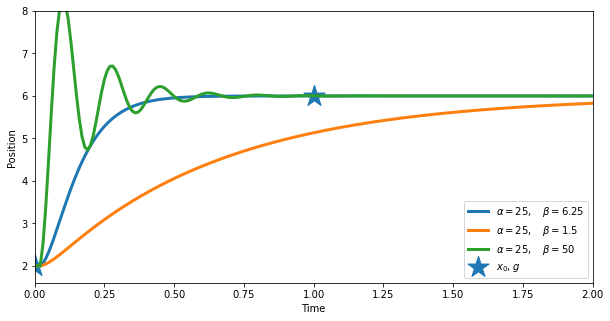

In [3]:
def spring_damper(x0, g, tau, dt, alpha, beta, observe_for):
    X = [x0]
    xd = 0.0
    xdd = 0.0
    t = 0.0
    i=0
    while t < observe_for:
        X.append(X[-1] + xd * dt)
        x = X[-1]
        xd += xdd * dt
        xdd = alpha / (tau ** 2) * (beta * (g - x) - tau * xd)
        t += dt
    return X

x0, g = 2.0, 6.0
tau = 1.0
observe_for = 2.0 * tau
dt = 0.01
plt.figure(figsize=(10, 5))
plt.xlabel("Time")
plt.ylabel("Position")
plt.xlim((0.0, observe_for))
diff = g - x0
plt.ylim((x0 - 0.1 * diff, g + 0.5 * diff))


for alpha, beta in [(25.0, 6.25), (25.0, 1.5), (25.0, 50.0)]:
    X = spring_damper(x0, g, tau, dt, alpha, beta, observe_for)
    plt.plot(np.arange(0.0, observe_for + dt, dt), X, lw=3,
             label="$\\alpha = %g,\\quad \\beta = %g$" % (alpha, beta))
plt.scatter([0.0, tau], [x0, g], marker="*", s=500, label="$x_0, g$")
plt.legend(loc="lower right")

IN Dynamic Motion Premitive  paper ( that we are working on currently ) the above equation is defined little bit different but essence is same .Critical Damping is achived when
$$ D = 2 \sqrt{K}$$
similar spring mass system code but with formulation given in paper eqn 1 

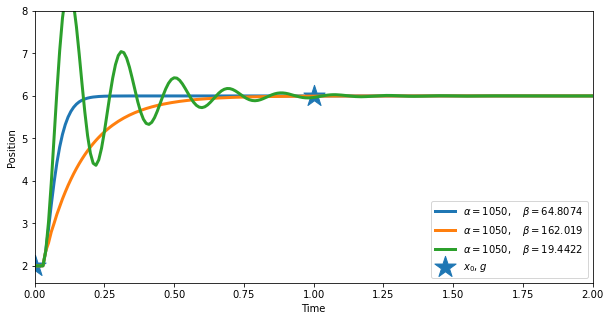

In [4]:

def phase(n_steps, alpha, t=None):
    """The phase variable replaces explicit timing.
    It starts with 1 at the beginning of the movement and converges
    exponentially to 0"""
    alpha_t = alpha/3
    phases = np.exp(-alpha_t * np.linspace(0, 1, n_steps))
    if t is None:
        return phases
    else:
        return phases[t]


def spring_damper(x0, g, tau, dt, alpha, beta, observe_for,S):
    K= alpha
    D= beta
    X = [x0]
    xd = 0.0
    xdd = 0.0
    t = 0.0
    i=0
    while t < observe_for:
        s=S[i]
        i+=1
        X.append(X[-1] + xd * dt)
        x = X[-1]
        xd += xdd * dt
        xdd = K*(g - x) - tau*D*xd - K*(g-x0)*s   #alpha / (tau ** 2) * (beta * (g - x) - tau * xd)
        t += dt
    #pdb.set_trace()
    return X

x0, g = 2.0, 6.0 #Xo is inital position and g is final goal position
tau = 1.0
observe_for = 2.0 * tau
dt = 0.01
n_internal_steps = int(observe_for/dt)
plt.figure(figsize=(10, 5))
plt.xlabel("Time")
plt.ylabel("Position")
plt.xlim((0.0, observe_for))
diff = g - x0
plt.ylim((x0 - 0.1 * diff, g + 0.5 * diff))

#first aplha,beta pair is crtical damping ie K= 1050, D = 2*(1050^(0.5)) blue line in graph
for alpha, beta in [(1050, 2*(1050**0.5)), (1050, 5*(1050**0.5)),(1050, 0.6*(1050**0.5))]:
    S = phase(n_internal_steps + 1,alpha)
    X = spring_damper(x0, g, tau, dt, alpha, beta, observe_for , S )
    plt.plot(np.arange(0.0, observe_for + dt, dt), X, lw=3,
             label="$\\alpha = %g,\\quad \\beta = %g$" % (alpha, beta))
plt.scatter([0.0, tau], [x0, g], marker="*", s=500, label="$x_0, g$")
plt.legend(loc="lower right")


Above casesa are in one dimension, we do the same thing in 2d; where we will have two dynamical equation  each for every dimension  and adding one extra term for obstacle potential

following code is for showing trajectory with dmp  formulation given in paper with f=0 and very simple obstacle potential function 

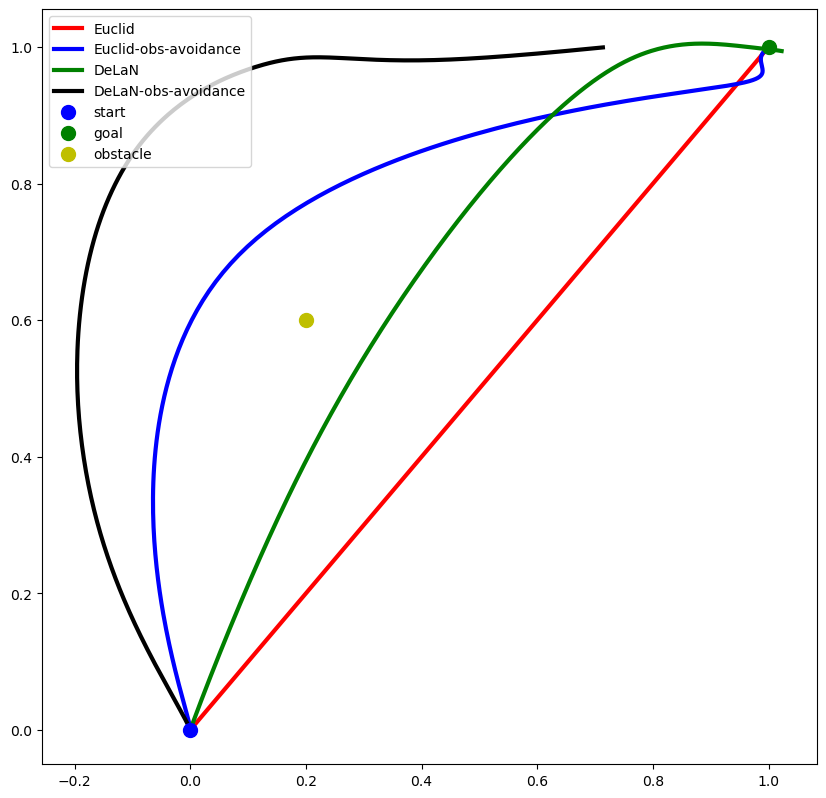

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dmp import DMP
import pdb

import matplotlib.colors
import matplotlib.pyplot as plt


from dmp import DMP, trajectory,potential_field

x0 = np.array([0, 0,0], dtype=np.float64)
g = np.array([1, 1, 0 ], dtype=np.float64)
tau = 4.0
w = np.array([[-50.0, 100.0, 300.0],
              [-200.0, -200.0, -200.0]])
o = np.array([0.2, 0.6,0.0])
dt = 0.01

dmp = DMP()

x_range = (-0.4, 1.4)
y_range = (-0.4, 1.4)
n_tics = 10

E, _, _ = trajectory(dmp, w, x0, g, tau, dt, o, shape=False, avoidance=False)
Eo, _, _ = trajectory(dmp, w, x0, g, tau, dt, o, shape=False , avoidance=True)

D, _, _ = trajectory(dmp, w, x0, g, tau, dt, o, shape=False, avoidance=False,delan = True)
Do, _, _ = trajectory(dmp, w, x0, g, tau, dt, o, shape=False, avoidance=True,delan = True)

fig =plt.figure(figsize=(10, 10),dpi = 100)
ax = fig.add_subplot()
plt.plot(E[:, 0], E[:, 1], lw=3, color="r", label="Euclid")
plt.plot(Eo[:, 0], Eo[:, 1], lw=3, color="b", label="Euclid-obs-avoidance")

plt.plot(D[:, 0], D[:, 1], lw=3, color="g", label="DeLaN")
plt.plot(Do[:, 0], Do[:, 1], lw=3, color="k", label="DeLaN-obs-avoidance")


plt.plot(x0[0], x0[1], "o", color="b", markersize=10,label='start')
plt.plot(g[0], g[1], "o", color="g", markersize=10 , label='goal')
plt.plot(o[0], o[1], "o", color="y", markersize=10 ,  label = 'obstacle')
ax.legend(loc="upper left")

plt.show()

#clean_ax(plt.gca(), x_range=x_range, y_range=y_range, legend=True)
#pdb.set_trace()



Following code show different terms in formulation

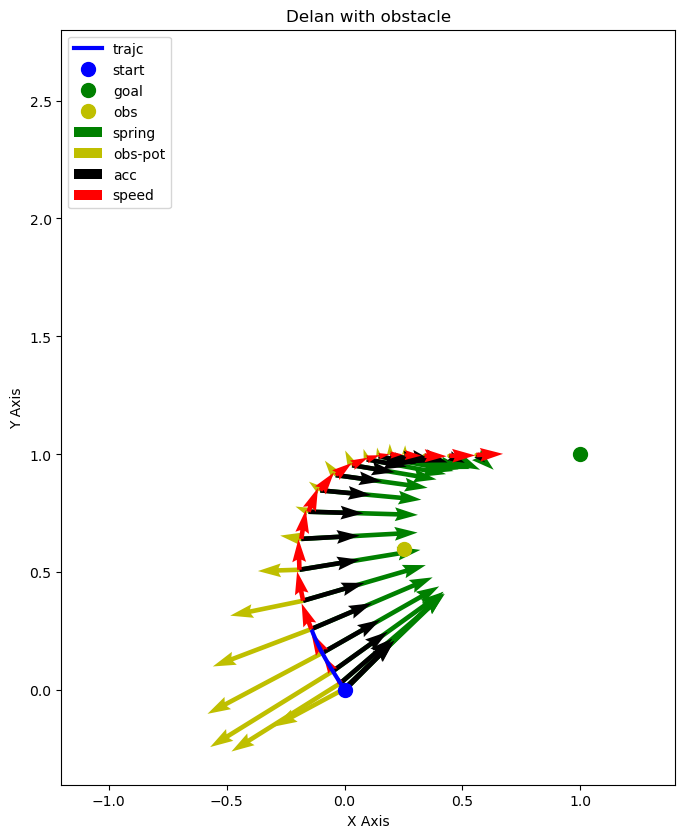

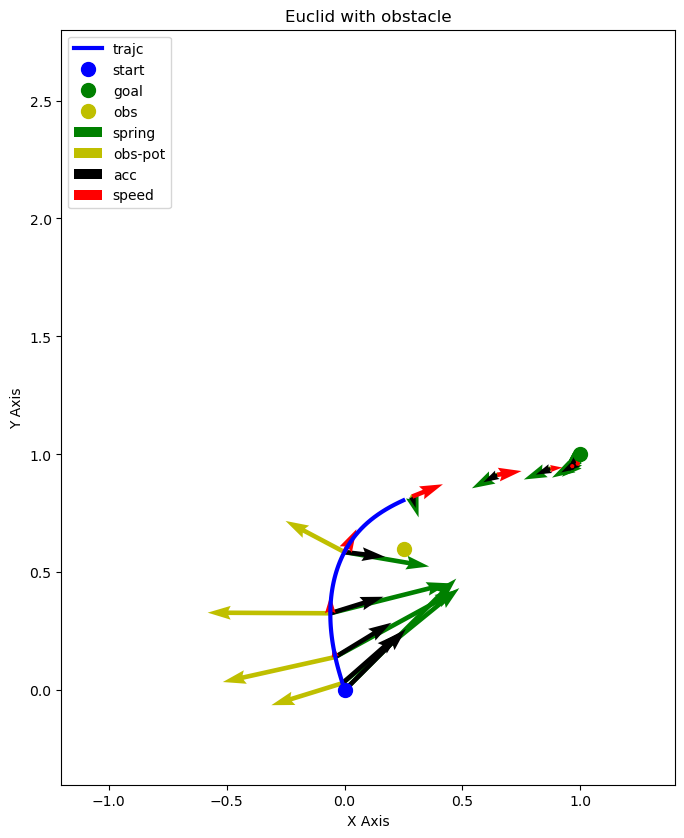

In [21]:
def potential_trajectory(dmp, t_max, dt, shape, avoidance,delan=True):
    DELAN = delan
    T, Td, _ = trajectory(dmp, w, x0, g, tau, dt, o, shape, avoidance, delan = delan )
    #pdb.set_trace()
    X, Y, sd, f, C, acc,cart_pos,xd = potential_field(
        dmp, t_max,T, Td,
        w, x0, g, tau, dt, o, x_range, y_range, n_tics)
    if not avoidance:
        acc -= C
    return T[:t_max], X, Y, sd, f, C, acc,cart_pos,xd

t = 99
DELAN = [True, False]
for de in DELAN:
    fig = plt.figure(figsize=(10, 10),dpi = 100)
    ax = fig.add_subplot()
    T, X, Y, sd, f, C, acc,cart_pos,xd = potential_trajectory(
        dmp, t, dt, shape=False, avoidance=True,delan=de)


    plt.plot(T[:, 0], T[:, 1], lw=3, color="b",label='trajc')

    quiver_scale = np.abs(xd).max() * n_tics
    #pdb.set_trace()
    X = cart_pos[:,0]
    Y = cart_pos[:,1]
    #pdb.set_trace()
    quiver_scale = np.abs(sd).max() * n_tics
    plt.quiver(X, Y, sd[:,  0], sd[:,  1], scale = quiver_scale/2, color="g",label='spring')
    quiver_scale = np.abs(C).max() * n_tics
    plt.quiver(X, Y, C[:,  0], C[:,  1], scale = quiver_scale/2 , color="y",label='obs-pot')
    quiver_scale = np.abs(acc).max() * n_tics
    plt.quiver(X, Y, acc[:,  0], acc[:, 1], scale =quiver_scale , color="black",label='acc')
    quiver_scale = np.abs(xd).max() * n_tics
    plt.quiver(X, Y, xd[:,0], xd[:, 1], scale = 2*quiver_scale , color="r",label='speed')

    plt.plot(x0[0], x0[1], "o", color="b", markersize=10,label='start')
    plt.plot(g[0], g[1], "o", color="g", markersize=10,label = 'goal')
    plt.plot(o[0], o[1], "o", color="y", markersize=10,label='obs')
    ax.set_xlim(3*x_range[0], x_range[1])
    ax.set_ylim(y_range[0],2*y_range[1])
    #ax.set_zlim3d(-1.0, 2.0)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    #ax.set_zlabel('Z Axis')
    ax.set_aspect('equal')
    ax.legend(loc="upper left")
    if de:
        plt.title("Delan with obstacle")
    else:
        plt.title("Euclid with obstacle")
    plt.show()